  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:05<00:00, 1744.39it/s]


Generated Points


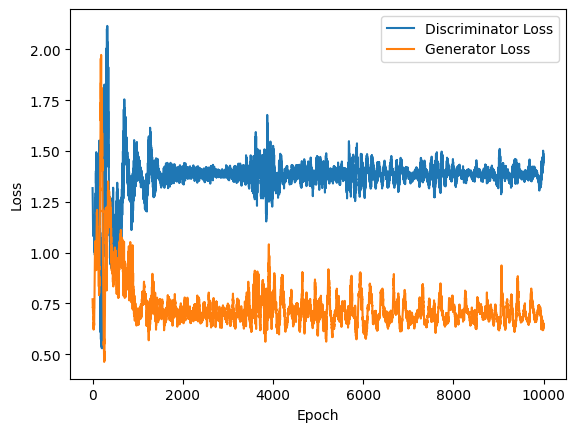

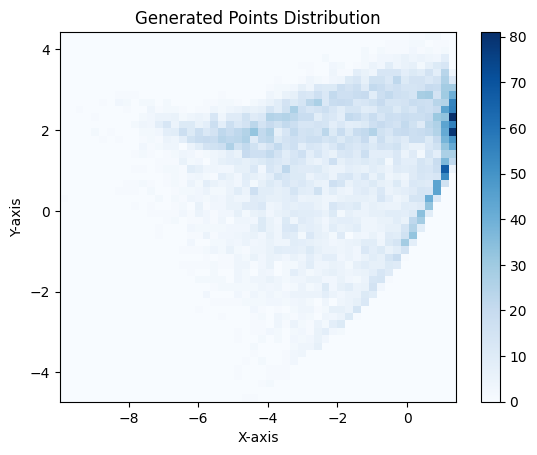

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from tqdm import tqdm

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Define the parameters of the bivariate distribution
mu1 = torch.tensor([0, 0], dtype=torch.float32)
mu2 = torch.tensor([2, 2], dtype=torch.float32)
mu3 = torch.tensor([-2, 2], dtype=torch.float32)
sigma = 2

# Generate 10,000 samples from the bivariate distribution
samples = np.concatenate([
    np.random.multivariate_normal(mu1, sigma * np.eye(2), 3333),
    np.random.multivariate_normal(mu2, sigma * np.eye(2), 3333),
    np.random.multivariate_normal(mu3, sigma * np.eye(2), 3334)
])

# Define the generator and discriminator networks
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 2)
        )

    def forward(self, z):
        return self.model(z)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# Initialize the generator and discriminator
generator = Generator()
discriminator = Discriminator()

# Define the loss function and optimizers
criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.001)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.001)

# Training the GAN
num_epochs = 10000
batch_size = 64

# Lists to store discriminator and generator losses for each epoch
d_losses = []
g_losses = []

for epoch in tqdm(range(num_epochs)):
    # Generate random noise samples
    z = Variable(torch.randn(batch_size, 2))

    # Generate fake samples using the generator
    fake_samples = generator(z)

    # Generate real samples from the true distribution
    real_samples = Variable(torch.tensor(samples[np.random.choice(10000, batch_size)], dtype=torch.float32))

    # Train the discriminator
    optimizer_D.zero_grad()

    # Discriminator loss for real samples
    real_labels = Variable(torch.ones(batch_size, 1))
    real_loss = criterion(discriminator(real_samples), real_labels)

    # Discriminator loss for fake samples
    fake_labels = Variable(torch.zeros(batch_size, 1))
    fake_loss = criterion(discriminator(fake_samples.detach()), fake_labels)

    # Total discriminator loss
    d_loss = real_loss + fake_loss
    d_loss.backward()
    optimizer_D.step()

    # Train the generator
    optimizer_G.zero_grad()
    fake_labels = Variable(torch.ones(batch_size, 1))

    # Generator loss
    g_loss = criterion(discriminator(fake_samples), fake_labels)
    g_loss.backward()
    optimizer_G.step()
    
    # Append discriminator and generator losses for plotting
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

# Generate points from the trained GAN
num_generated_points = 10000
generated_points = generator(Variable(torch.randn(num_generated_points, 2))).detach().numpy()
print("Generated Points")

# Plot the Loss vs Epoch curve
plt.plot(range(num_epochs), d_losses, label="Discriminator Loss")
plt.plot(range(num_epochs), g_losses, label="Generator Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Generate histogram plot of the generated points
plt.hist2d(generated_points[:, 0], generated_points[:, 1], bins=50, cmap='Blues')
plt.title("Generated Points Distribution")
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.colorbar()
plt.show()
